In [1]:
import scapy as scapy
from scapy.utils import PcapReader
from scapy import layers
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass

In [2]:
@dataclass
class INTOption:
    kind: int       # 8 bits
    length: int     # 8 bits
    switch_id: int  # 16 bits
    latency_ns: int # 32 bits

In [3]:
LOG = True

In [4]:
DUMP_DIRECTORY = "./tcpdump_logs/"
# PCAP_FILE = DUMP_DIRECTORY + "dlint_1_flow/5mbps.pcap"
# PCAP_FILE = DUMP_DIRECTORY + "forw_1_flow/5mbps.pcap"
PCAP_FILE = DUMP_DIRECTORY + "plint_1_flow/5mbps.pcap"

assert os.path.exists(PCAP_FILE), "The path to the pcap file is incorrect."

In [5]:
pcap = PcapReader(PCAP_FILE)

options = []

for index, pkt in enumerate(pcap):
    pkt: scapy.packet.Packet

    if pkt.haslayer(layers.inet.TCP):
        for option in pkt.getlayer(layers.inet.TCP).options:
            if option[0] == 114:
                print(' '.join([hex(x)[2:].zfill(2) for x in option[1]]))
            
                values = ''.join([hex(x)[2:].zfill(2) for x in option[1]])
                kind = int(values[0:2], base=16)
                length = int(values[2:4], base=16)
                padding = int(values[4:12], base=16)
                latency = int(values[12:20], base=16)
                if values[20:]:
                    print(f"ERROR: There are more bytes than expected in the option. {values}")
                    exit(1)

                if latency == 0:
                    continue

                options.append(INTOption(kind, length, switch_id, latency))

                if index % 500 == 0:
                    print(f"Processed {index} packets.")

            if index == 20:
                break

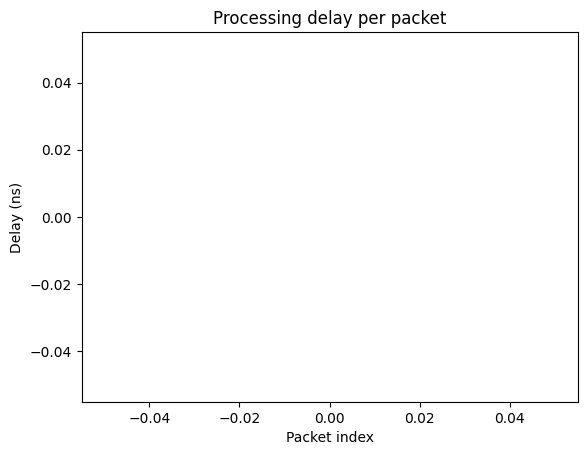

In [6]:
delays = np.array([option.latency_ns for option in options])
plt.plot(delays, color='blue', linestyle='solid')
plt.ylabel('Delay (ns)')
plt.xlabel('Packet index')
plt.title('Processing delay per packet')

plt.show()

/home/tim/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tim/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tim/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tim/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/tim/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


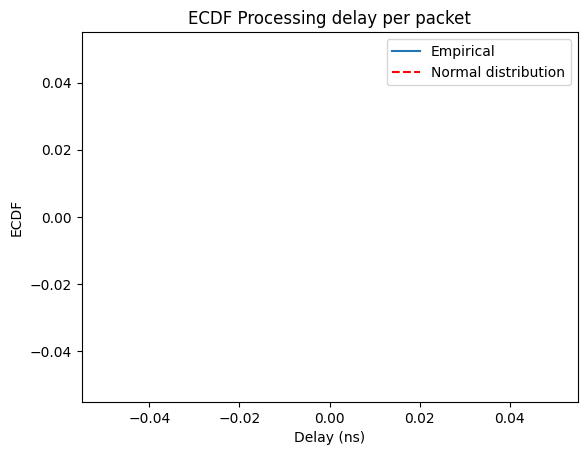

In [7]:
# Create ECDF plot
x = np.sort(delays)
y = np.arange(1, len(x) + 1) / len(x)
plt.plot(x, y, label='Empirical')
plt.ylabel('ECDF')
plt.xlabel('Delay (ns)')
plt.title('ECDF Processing delay per packet')

mean = np.mean(delays)
std = np.std(delays)
standard_dist = np.random.normal(mean, std, len(delays))
x = np.sort(standard_dist)
y = np.arange(1, len(x) + 1) / len(x)
plt.plot(x, y, color='red', linestyle='--', label='Normal distribution')

plt.legend()
plt.show()